# Лабораторна робота #2

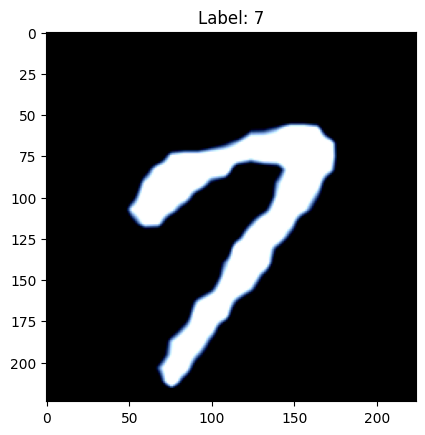

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

generator = torch.Generator().manual_seed(5921)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = datasets.MNIST('mnist_data', download=True, transform=transform)
img, lbl = dataset[15]
# rearrange from CxHxW to HxWxC && set value between 0 and 1
img = img.permute(1, 2, 0).clamp(0, 1)

plt.imshow(img)
plt.title(f"Label: {lbl}")
plt.show()

In [2]:
class UnlabeledDataset(data.Dataset):
    def __init__(self, labeled_dataset):
        self.labeled_dataset = labeled_dataset

    def __len__(self):
        return len(self.labeled_dataset)

    def __getitem__(self, idx):
        input_data, _ = self.labeled_dataset[idx]
        return input_data

In [3]:
training_lbl_set, training_clr_set, validation_set = data.random_split(dataset, [0.24, 0.56, 0.2], generator)
training_clr_set = UnlabeledDataset(training_clr_set)

train_lbl_loader = torch.utils.data.DataLoader(training_lbl_set, batch_size=128, shuffle=True)
train_clr_loader = torch.utils.data.DataLoader(training_clr_set, batch_size=128, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=128, shuffle=False)

model = models.alexnet(weights=None)
model.classifier[6] = nn.Linear(4096, 10)
for m in model.modules():
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


In [4]:
num_epochs = 15
threshold = 0.94

train_losses = []
test_accuracies = []

print("Starting Training!")

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    total_samples = 0

    # Training on labeled data
    for images, labels in train_lbl_loader:
        images = images.to(device)
        labels = labels.to(device)
        total_samples += labels.size(0)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        train_loss += loss.item() * labels.size(0)  # Scale loss by batch size

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch+1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{epoch+1}/{len(train_lbl_loader)}], Loss: {loss.item():.4f}')

    # Training on pseudo-labeled data
    for images in train_clr_loader:
        model.eval()
        with torch.no_grad():
            images = images.to(device)
            outputs = model(images)
            probabilities = torch.softmax(outputs, dim=1)
            max_probs, pseudo_labels = torch.max(probabilities, dim=1)
            mask = max_probs.ge(threshold)  # Select samples where the model is confident

        if mask.sum() > 0:
            selected_images = images[mask]
            selected_labels = pseudo_labels[mask]

            model.train()
            optimizer.zero_grad()
            outputs = model(selected_images)
            pseudo_loss = criterion(outputs, selected_labels)
            train_loss += pseudo_loss.item() * selected_labels.size(0)
            total_samples += mask.sum()

            pseudo_loss.backward()
            optimizer.step()

            if (epoch+1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{epoch+1}/{len(train_clr_loader)}], Loss: {pseudo_loss.item():.4f}')

    # Validation
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in validation_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    scheduler.step()
    test_accuracy = correct / total
    test_accuracies.append(test_accuracy)

    average_train_loss = train_loss / total_samples
    train_losses.append(average_train_loss)
    print(f'Accuracy of the model on test images: {correct / total:.2%}')
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {average_train_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
    


Starting Training!
Accuracy of the model on test images: 91.68%
Epoch [1/15], Average Loss: 0.3029, Test Accuracy: 0.9168
Accuracy of the model on test images: 96.16%
Epoch [2/15], Average Loss: 0.0546, Test Accuracy: 0.9616
Accuracy of the model on test images: 97.90%
Epoch [3/15], Average Loss: 0.0364, Test Accuracy: 0.9790
Accuracy of the model on test images: 97.47%
Epoch [4/15], Average Loss: 0.0280, Test Accuracy: 0.9747
Accuracy of the model on test images: 96.43%
Epoch [5/15], Average Loss: 0.0215, Test Accuracy: 0.9643
Accuracy of the model on test images: 98.70%
Epoch [6/15], Average Loss: 0.0224, Test Accuracy: 0.9870
Accuracy of the model on test images: 98.79%
Epoch [7/15], Average Loss: 0.0117, Test Accuracy: 0.9879
Accuracy of the model on test images: 98.78%
Epoch [8/15], Average Loss: 0.0101, Test Accuracy: 0.9878
Accuracy of the model on test images: 98.90%
Epoch [9/15], Average Loss: 0.0090, Test Accuracy: 0.9890
Accuracy of the model on test images: 98.91%
Epoch [10

In [6]:
model.eval() 
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in validation_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    test_accuracy = correct / total
    test_accuracies.append(test_accuracy)
        
    print(f'Accuracy of the model test images: {correct / total:.2%}')

Accuracy of the model test images: 98.96%


In [7]:
torch.save(model.state_dict(), "weights2.pth")

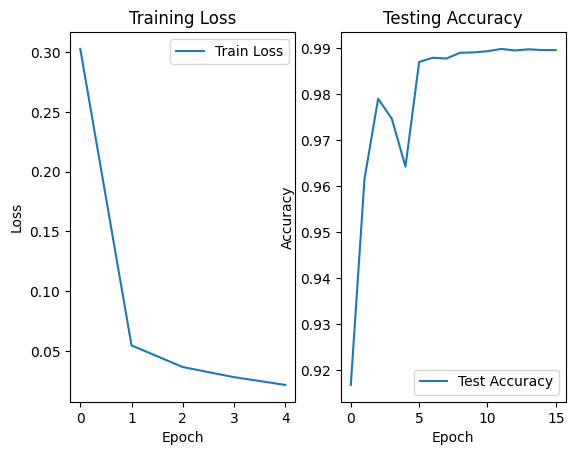

In [38]:
train_losses_cpu = [loss.cpu() for loss in train_losses]

plt.subplot(1, 2, 1)
plt.plot(train_losses_cpu, label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()